# 제 1차 해커톤 : 캐글 축제

# Predict Future Sals - 미래의 매출 및 판매 예측

### [ 대회 소개 ]
러시아 소프트 회사 중 하나인 1C 회사에서 제공하는 일일 판매 데이터를 가지고, 다음 달의 모든 제품과 매장에 대한 총 매출을 예측해야합니다.

### [ 점수 평가 기준 ]
대회의 평가 방식은 RMSE (Root Mean Squared Error) 입니다.
> RMSE : 실제 정답과 예측한 값의 차이의 제곱을 평균한 값의 제곱근  

$${\sqrt{ {1 \over N} \sum{(y_t - y_{pr})}^2}}$$

### [ 데이터 설명 ]
- sales_train.csv : 2013년 1월부터 2015년 10월까지의 판매 기록 데이터를 가지는 학습데이터
- test.csv : 2015년 11월 매출 데이터를 가지는 평가데이터
- sample_submission.csv : 캐글제출양식
- items.csv : item(제품)에 대한 추가 정보
- item_categories.csv : item(제품) 카테고리에 대한 추가 정보
- shops.csv : shops(가게)에 대한 추가 정보

> ID : test 데이터 내의 번호  
shop_id : 가게 고유 식별자  
item_id : 제품 고유 식별자  
item_category_id : 제품의 카테고리 고유 식별자  
item_cnt_day : 하루 판매된 제품수  
item_price : 제품의 가격  
date : dd/mm/yyyy 형식의 날짜  
date_block_num : 편의상 사용되는 연속 월 번호 ex) 2013년 1월 : 0, 2013년 2월 : 1, ...  
item_name : 제품 이름  
shop_name : 가게 이름  
item_category_name : 제품의 카테고리 이름  

우리가 예측해야하는 컬럼은 item_cnt_month 입니다.

### [ 목차 ]
### 1. EDA 및 전처리
### 2. 모델링
### 3. 하이퍼파라미터 튜닝
### 4. 결과

## 1. EDA 및 전처리

### 1) 데이터 불러오기

In [1]:
import os
from os.path import join
import pandas as pd 
import numpy as np

data_dir = os.getenv('HOME')+'/aiffel/Hackathon_01/data'

train_path = join(data_dir, 'sales_train.csv')
test_path = join(data_dir, 'test.csv') 
items_path = join(data_dir, 'items.csv') 
item_categories_path = join(data_dir, 'item_categories.csv') 
shops_path = join(data_dir, 'shops.csv') 

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
items_data = pd.read_csv(items_path)
item_categories_data = pd.read_csv(item_categories_path)
shops_data = pd.read_csv(shops_path)

train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
items = pd.read_csv(items_path)
item_categories = pd.read_csv(item_categories_path)
shops = pd.read_csv(shops_path)

print('train data shape : {}'.format(train.shape))
print('test data shape : {}'.format(test.shape))
print('items data shape : {}'.format(items.shape))
print('item_categories data shape : {}'.format(item_categories.shape))
print('shops data shape : {}'.format(shops.shape))


train data shape : (2935849, 6)
test data shape : (214200, 3)
items data shape : (22170, 3)
item_categories data shape : (84, 2)
shops data shape : (60, 2)


### 2) train 데이터와 test 데이터 살펴보기

In [2]:
print('train data shape : {}'.format(train.shape))

train.info()

train data shape : (2935849, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
print('test data shape : {}'.format(test.shape))

test.info()

test data shape : (214200, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [5]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


### 3) item_price 컬럼 삭제하기

In [6]:
print('제거 전의 train data shape : {}'.format(train.shape))

train.drop('item_price', axis=1, inplace=True)

print('제거 후의 train data shape : {}'.format(train.shape))

train.head()

제거 전의 train data shape : (2935849, 6)
제거 후의 train data shape : (2935849, 5)


,date,date_block_num,shop_id,item_id,item_cnt_day
0,02.01.2013,0,59,22154,1.0
1,03.01.2013,0,25,2552,1.0
2,05.01.2013,0,25,2552,-1.0
3,06.01.2013,0,25,2554,1.0
4,15.01.2013,0,25,2555,1.0


### 4) train 데이터에서 test 데이터에 없는 제품과 가게 없애기

In [7]:
print('제거 전의 train data shape : {}'.format(train.shape))

test_shops = test.shop_id.unique()
test_items = test.item_id.unique()

train = train[train.shop_id.isin(test_shops)]
train = train[train.item_id.isin(test_items)]

print('제거 후의 train data shape : {}'.format(train.shape))

train.head()

제거 전의 train data shape : (2935849, 5)
제거 후의 train data shape : (1224439, 5)


,date,date_block_num,shop_id,item_id,item_cnt_day
0,02.01.2013,0,59,22154,1.0
10,03.01.2013,0,25,2574,2.0
11,05.01.2013,0,25,2574,1.0
12,07.01.2013,0,25,2574,1.0
13,08.01.2013,0,25,2574,2.0


### 5) date 컬럼은 삭제하고 month 컬럼과 year 컬럼 추가하기

In [8]:
print('변경 전의 train data shape : {}'.format(train.shape))

year = train['date'].apply(lambda x : str(x[6:])).astype(int)
month = train['date'].apply(lambda x : str(x[3:5])).astype(int)

train = train.assign(year = year)
train = train.assign(month = month)

train.drop('date', axis=1, inplace=True)

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 5)
변경 후의 train data shape : (1224439, 6)


,date_block_num,shop_id,item_id,item_cnt_day,year,month
0,0,59,22154,1.0,2013,1
10,0,25,2574,2.0,2013,1
11,0,25,2574,1.0,2013,1
12,0,25,2574,1.0,2013,1
13,0,25,2574,2.0,2013,1


### 6) shops.csv 를 통해 city 컬럼 추가하기

In [9]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
city = shops["shop_name"].apply(lambda x: str.replace(x, '!', '')).apply(lambda x: x.split(' ')[0])

shops['city'] = city
shops['city_id'] = pd.Categorical(city).codes

shops.head()

,shop_name,shop_id,city,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,29
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,29
2,"Адыгея ТЦ ""Мега""",2,Адыгея,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,1
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,2


In [11]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, shops.loc[:,['shop_id', 'city_id']], on="shop_id", how="left")

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 6)
변경 후의 train data shape : (1224439, 7)


,date_block_num,shop_id,item_id,item_cnt_day,year,month,city_id
0,0,59,22154,1.0,2013,1,30
1,0,25,2574,2.0,2013,1,13
2,0,25,2574,1.0,2013,1,13
3,0,25,2574,1.0,2013,1,13
4,0,25,2574,2.0,2013,1,13


### 7) items.csv 를 통해 item_category_id 컬럼 추가하기

In [12]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, items.loc[:, ['item_id', 'item_category_id']], on="item_id", how="left")

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 7)
변경 후의 train data shape : (1224439, 8)


,date_block_num,shop_id,item_id,item_cnt_day,year,month,city_id,item_category_id
0,0,59,22154,1.0,2013,1,30,37
1,0,25,2574,2.0,2013,1,13,55
2,0,25,2574,1.0,2013,1,13,55
3,0,25,2574,1.0,2013,1,13,55
4,0,25,2574,2.0,2013,1,13,55


### 8) item_categories.csv 를 통해 item_category_id2 컬럼 추가하기

In [14]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [15]:
item_category_id2 = item_categories['item_category_name'].apply(lambda x: str(x).split(' ')[0])

item_categories["item_category_name2"] = item_category_id2
item_categories["item_category_id2"] = pd.Categorical(item_category_id2).codes

item_categories.head()

,item_category_name,item_category_id,item_category_name2,item_category_id2
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1


In [16]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, item_categories.loc[:, ['item_category_id', 'item_category_id2']], on="item_category_id", how="left")

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 8)
변경 후의 train data shape : (1224439, 9)


,date_block_num,shop_id,item_id,item_cnt_day,year,month,city_id,item_category_id,item_category_id2
0,0,59,22154,1.0,2013,1,30,37,7
1,0,25,2574,2.0,2013,1,13,55,9
2,0,25,2574,1.0,2013,1,13,55,9
3,0,25,2574,1.0,2013,1,13,55,9
4,0,25,2574,2.0,2013,1,13,55,9


### 9) groupby 를 활용하여 item_cnt_month 컬럼 추가하기

In [17]:
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

group.head()

item_cnt_day
                                        sum
date_block_num shop_id item_id             
0              2       33               1.0
                       482              1.0
                       491              1.0
                       839              1.0
                       1007             3.0

In [18]:
group.columns = ['item_cnt_month']

group.head()

item_cnt_month
date_block_num shop_id item_id                
0              2       33                  1.0
                       482                 1.0
                       491                 1.0
                       839                 1.0
                       1007                3.0

In [19]:
group.reset_index(inplace=True)

group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,33,1.0
1,0,2,482,1.0
2,0,2,491,1.0
3,0,2,839,1.0
4,0,2,1007,3.0


In [20]:
print('변경 전의 train data shape : {}'.format(train.shape))

train = pd.merge(train, group, how='left')
train.drop('item_cnt_day', axis=1, inplace=True)

print('변경 후의 train data shape : {}'.format(train.shape))

train.head()

변경 전의 train data shape : (1224439, 9)
변경 후의 train data shape : (1224439, 9)


,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2,item_cnt_month
0,0,59,22154,2013,1,30,37,7,1.0
1,0,25,2574,2013,1,13,55,9,13.0
2,0,25,2574,2013,1,13,55,9,13.0
3,0,25,2574,2013,1,13,55,9,13.0
4,0,25,2574,2013,1,13,55,9,13.0


### 9) 결측치 제거하기

In [21]:
train.isnull().sum()

date_block_num       0
shop_id              0
item_id              0
year                 0
month                0
city_id              0
item_category_id     0
item_category_id2    0
item_cnt_month       0
dtype: int64

<AxesSubplot:>

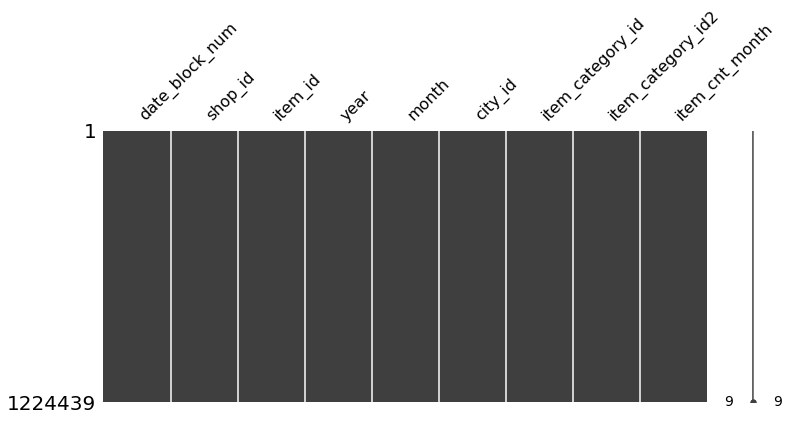

In [22]:
import missingno as msno

msno.matrix(train, figsize=(12,5))

### 10) 중복값 제거하기

In [23]:
print(len(train[train.duplicated()]))
train[train.duplicated()]

624280


,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2,item_cnt_month
2,0,25,2574,2013,1,13,55,9,13.0
3,0,25,2574,2013,1,13,55,9,13.0
4,0,25,2574,2013,1,13,55,9,13.0
5,0,25,2574,2013,1,13,55,9,13.0
6,0,25,2574,2013,1,13,55,9,13.0
...,...,...,...,...,...,...,...,...,...
1224426,33,25,7327,2015,10,13,55,9,2.0
1224433,33,25,7409,2015,10,13,55,9,3.0
1224434,33,25,7409,2015,10,13,55,9,3.0
1224435,33,25,7460,2015,10,13,55,9,3.0


In [24]:
print('중복 제거 전의 train data shape : {}'.format(train.shape))

train.drop_duplicates(inplace=True, ignore_index = True)

print('중복 제거 후의 train data shape : {}'.format(train.shape))

중복 제거 전의 train data shape : (1224439, 9)
중복 제거 후의 train data shape : (600159, 9)


In [25]:
train

,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2,item_cnt_month
0,0,59,22154,2013,1,30,37,7,1.0
1,0,25,2574,2013,1,13,55,9,13.0
2,0,25,2607,2013,1,13,55,9,2.0
3,0,25,2614,2013,1,13,55,9,2.0
4,0,25,2808,2013,1,13,30,5,30.0
...,...,...,...,...,...,...,...,...,...
600154,33,25,7409,2015,10,13,55,9,3.0
600155,33,25,7393,2015,10,13,55,9,1.0
600156,33,25,7384,2015,10,13,55,9,1.0
600157,33,25,7459,2015,10,13,55,9,1.0


### 11) test 데이터도 train 데이터처럼 바꾸기

In [26]:
print('변경 전의 test data shape : {}'.format(test.shape))

test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11

test = pd.merge(test, shops.loc[:,['shop_id', 'city_id']], on="shop_id", how="left")

test = pd.merge(test, items.loc[:, ['item_id', 'item_category_id']], on="item_id", how="left")

test = pd.merge(test, item_categories.loc[:, ['item_category_id', 'item_category_id2']], on="item_category_id", how="left")

test_id = test["ID"]

test.drop('ID', axis=1, inplace=True)

print('변경 후의 test data shape : {}'.format(test.shape))

test.head()

변경 전의 test data shape : (214200, 3)
변경 후의 test data shape : (214200, 8)


,shop_id,item_id,date_block_num,year,month,city_id,item_category_id,item_category_id2
0,5,5037,34,2015,11,3,19,5
1,5,5320,34,2015,11,3,55,9
2,5,5233,34,2015,11,3,19,5
3,5,5232,34,2015,11,3,23,5
4,5,5268,34,2015,11,3,20,5


In [27]:
print('train data shape : {}'.format(train.shape))
print('test data shape : {}'.format(test.shape))

train data shape : (600159, 9)
test data shape : (214200, 8)


### 12) 데이터 시각화

<AxesSubplot:xlabel='date_block_num', ylabel='item_cnt_month'>

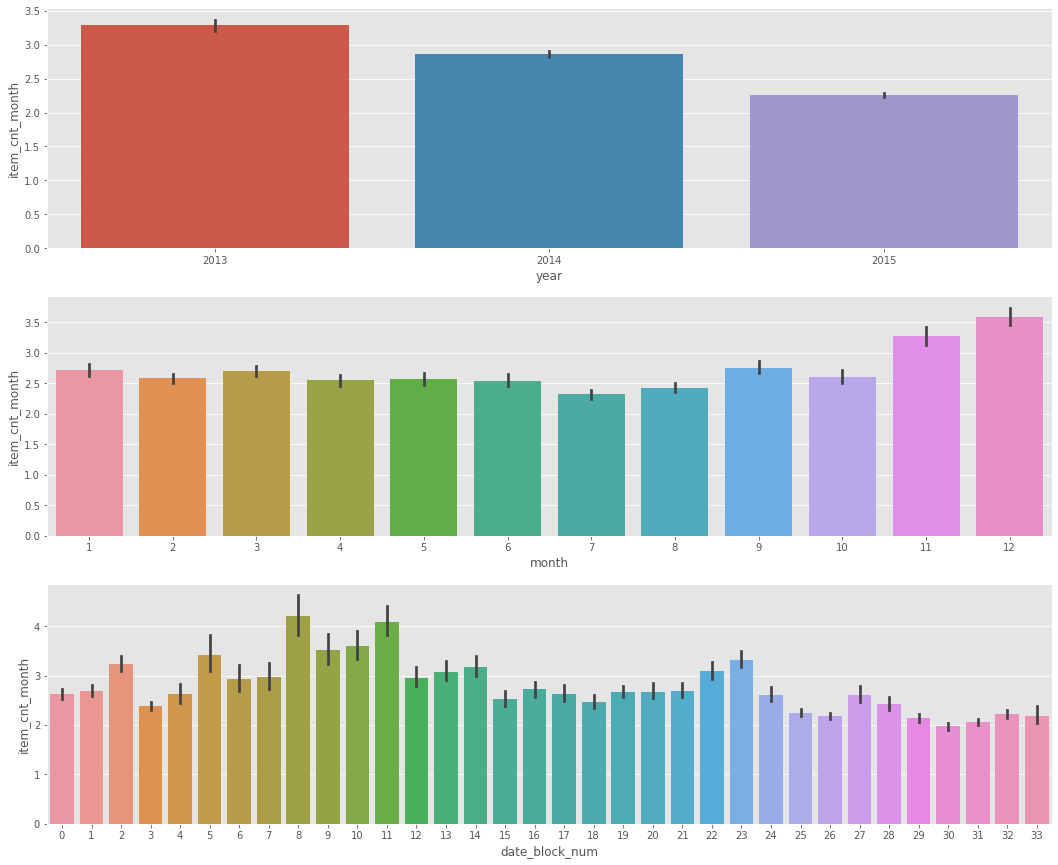

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 노트북 안에 그래프를 그리기 위해
%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1)
figure.set_size_inches(18,15)

sns.barplot(data=train, x="year", y="item_cnt_month", ax=ax1)
sns.barplot(data=train, x="month", y="item_cnt_month", ax=ax2)
sns.barplot(data=train, x="date_block_num", y="item_cnt_month", ax=ax3)


<AxesSubplot:xlabel='shop_id', ylabel='item_cnt_month'>

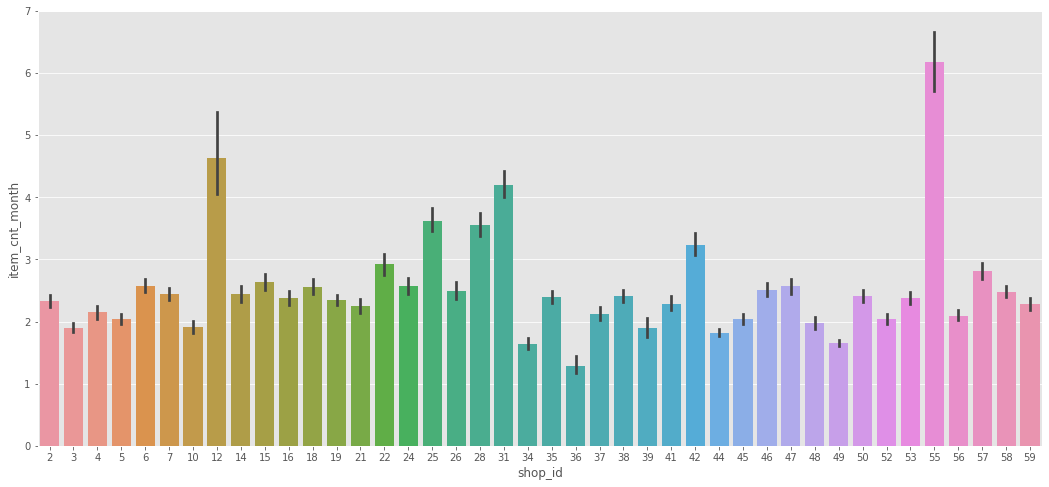

In [29]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="shop_id", y="item_cnt_month")

In [30]:
first = shops['shop_id'] == 53
second = shops['shop_id'] == 12
third = shops['shop_id'] == 31

print(shops[first]["shop_name"].values)   
print(shops[second]["shop_name"].values)
print(shops[third]["shop_name"].values)

['Уфа ТЦ "Семья" 2']
['Интернет-магазин ЧС']
['Москва ТЦ "Семеновский"']


<AxesSubplot:xlabel='city_id', ylabel='item_cnt_month'>

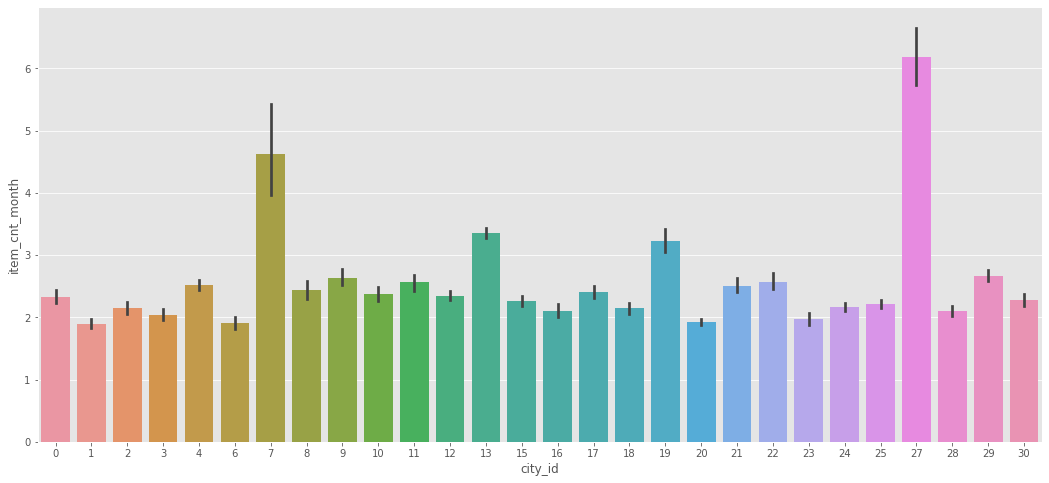

In [31]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="city_id", y="item_cnt_month")

In [32]:
first = shops['city_id'] == 27
second = shops['city_id'] == 7

print(shops[first]["city"].values)
print(shops[second]["city"].values)

['Цифровой']
['Интернет-магазин']


<AxesSubplot:xlabel='item_category_id', ylabel='item_cnt_month'>

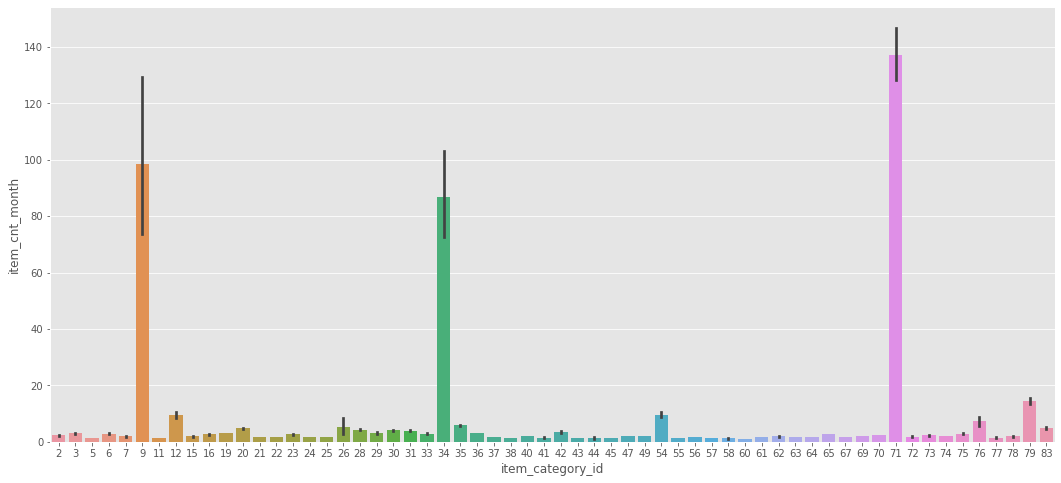

In [33]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="item_category_id", y="item_cnt_month")

In [34]:
first = item_categories['item_category_id'] == 71
second = item_categories['item_category_id'] == 9
third = item_categories['item_category_id'] == 34

print(item_categories[first]["item_category_name"].values)
print(item_categories[second]["item_category_name"].values)
print(item_categories[third]["item_category_name"].values)

['Подарки - Сумки, Альбомы, Коврики д/мыши']
['Доставка товара']
['Карты оплаты - Live! (Цифра)']


<AxesSubplot:xlabel='item_category_id2', ylabel='item_cnt_month'>

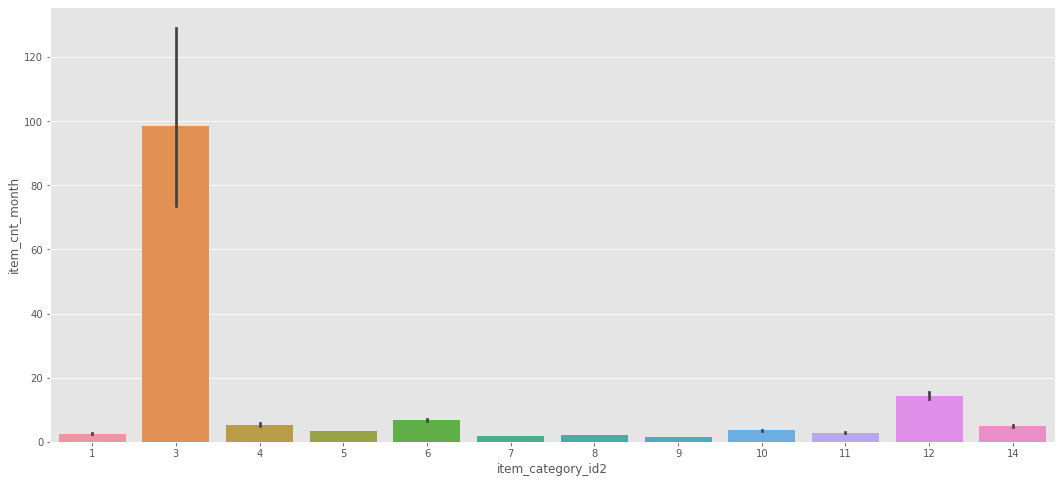

In [35]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.barplot(data=train, x="item_category_id2", y="item_cnt_month")

In [36]:
first = item_categories['item_category_id2'] == 3

print(item_categories[first]["item_category_name2"].values)

['Доставка']


(0.0, 2500.0)

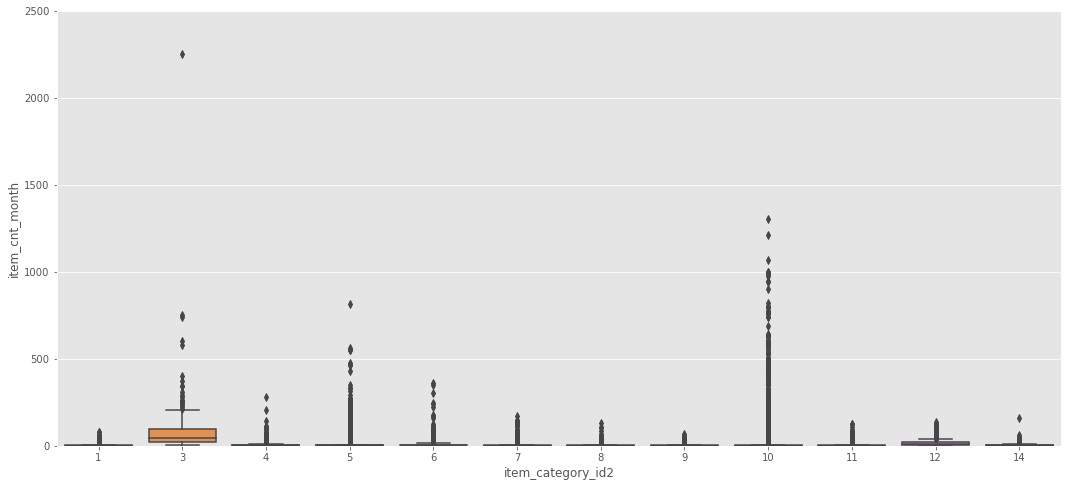

In [37]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="item_category_id2", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

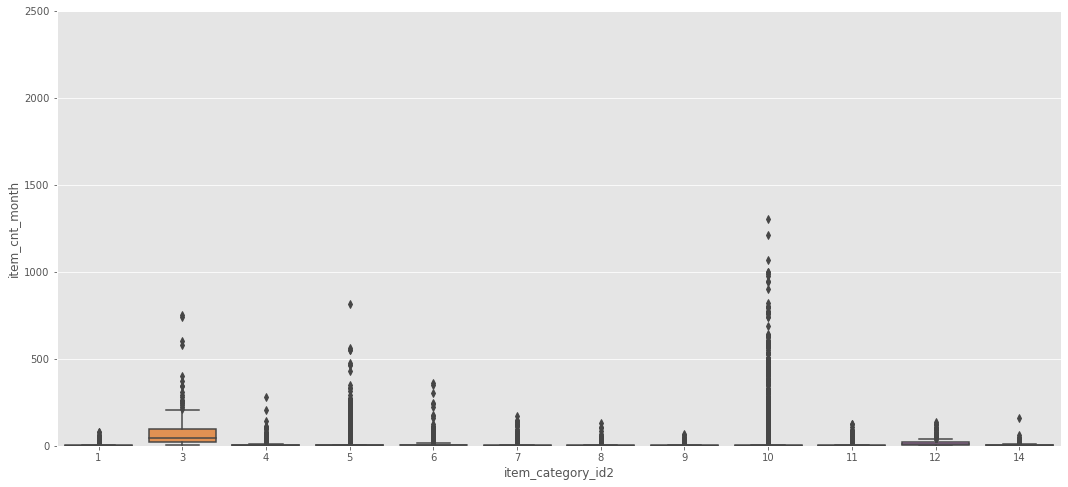

In [38]:
first = train["item_category_id2"] == 3
second = train['item_cnt_month'] > 2000
train = train.drop(train[first & second].index, axis=0)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="item_category_id2", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

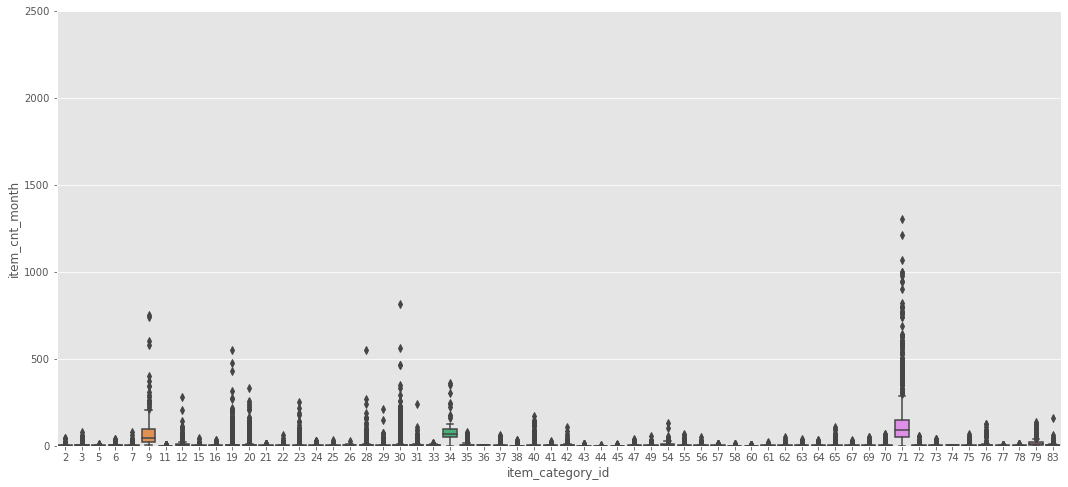

In [39]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="item_category_id", y="item_cnt_month",orient="v")
plt.ylim(0, 2500)

(0.0, 2500.0)

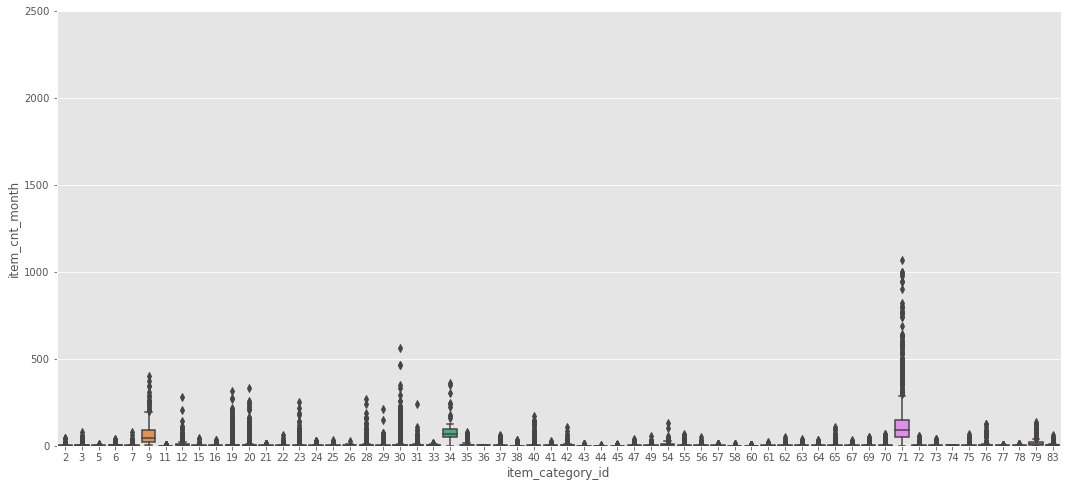

In [40]:
first = train["item_category_id"] == 9
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 19
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 28
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 30
second = train['item_cnt_month'] > 600
train = train.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 71
second = train['item_cnt_month'] > 1100
train = train.drop(train[first & second].index, axis=0)

first = train["item_category_id"] == 83
second = train['item_cnt_month'] > 100
train = train.drop(train[first & second].index, axis=0)


fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="item_category_id", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

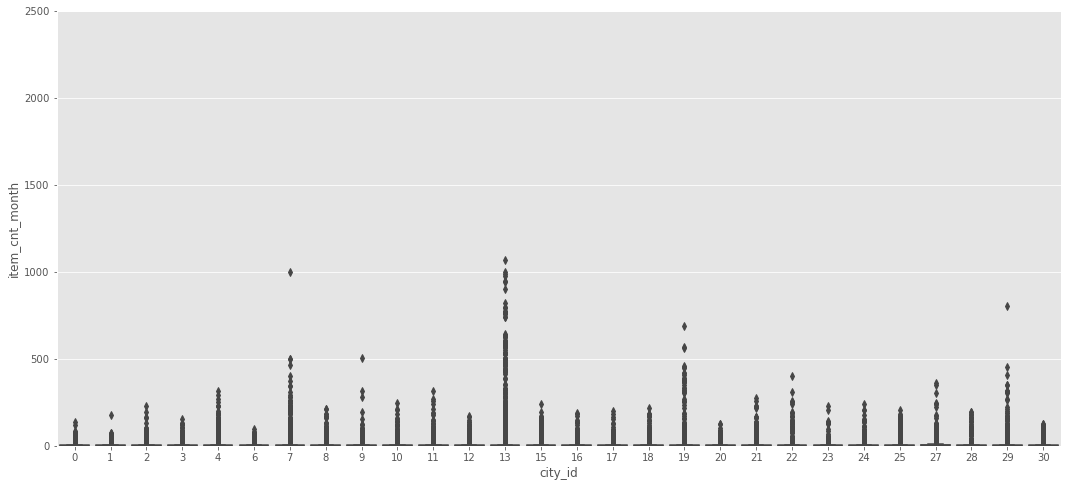

In [41]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="city_id", y="item_cnt_month",orient="v")
plt.ylim(0, 2500)

(0.0, 2500.0)

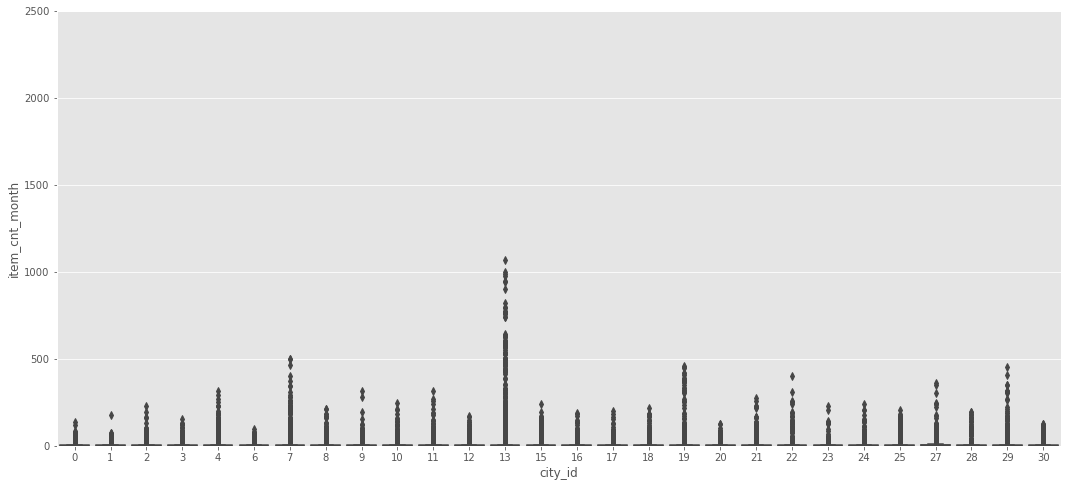

In [42]:
first = train["city_id"] == 7
second = train['item_cnt_month'] > 600
train = train.drop(train[first & second].index, axis=0)

first = train["city_id"] == 9
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["city_id"] == 13
second = train['item_cnt_month'] > 1100
train = train.drop(train[first & second].index, axis=0)

first = train["city_id"] == 19
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["city_id"] == 29
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)


fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="city_id", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

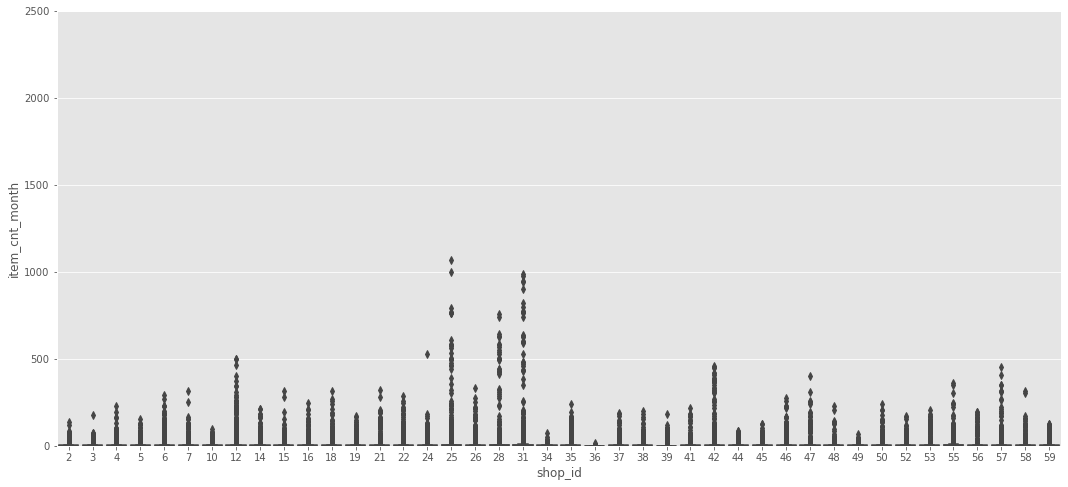

In [43]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="shop_id", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

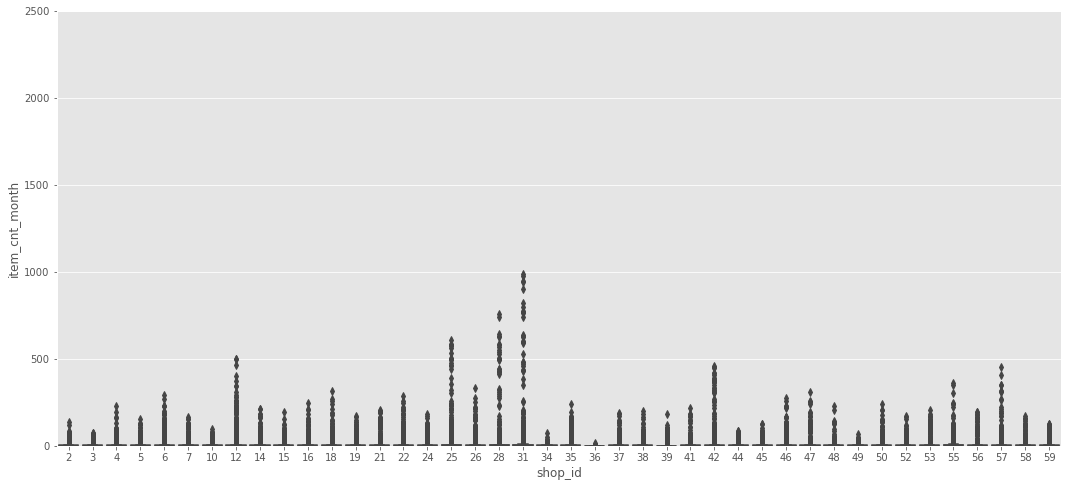

In [44]:
first = train["shop_id"] == 3
second = train['item_cnt_month'] > 150
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 7
second = train['item_cnt_month'] > 230
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 15
second = train['item_cnt_month'] > 250
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 21
second = train['item_cnt_month'] > 250
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 24
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 25
second = train['item_cnt_month'] > 700
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 47
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["shop_id"] == 58
second = train['item_cnt_month'] > 250
train = train.drop(train[first & second].index, axis=0)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="shop_id", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

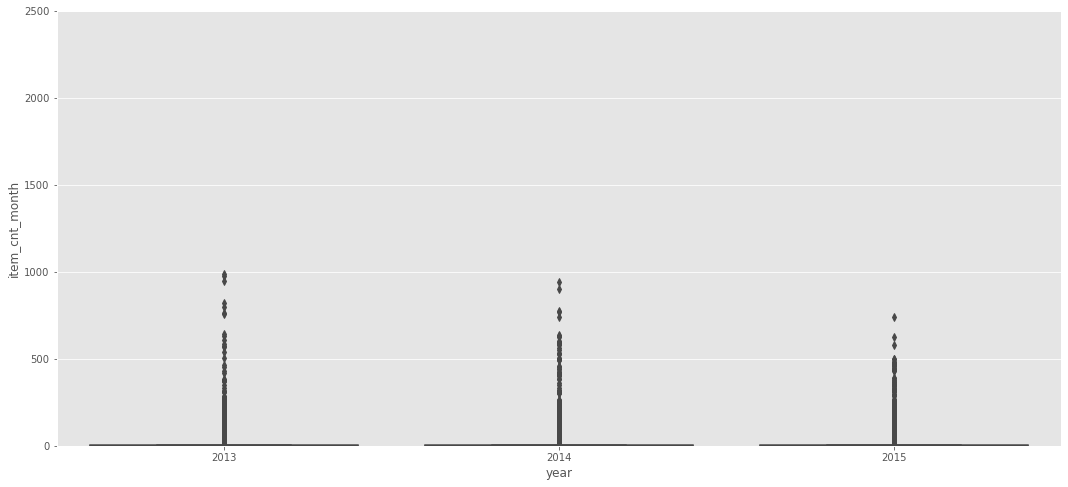

In [45]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="year", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

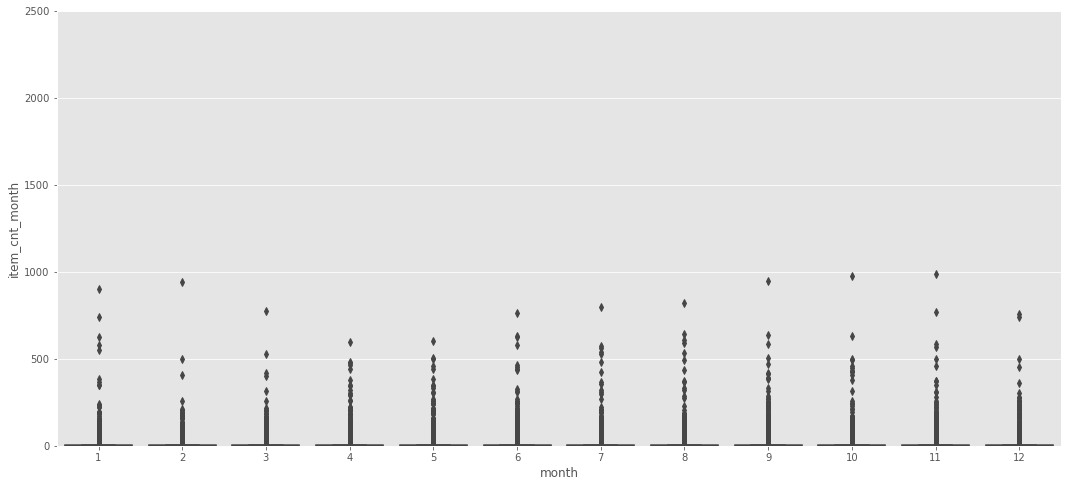

In [46]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="month", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

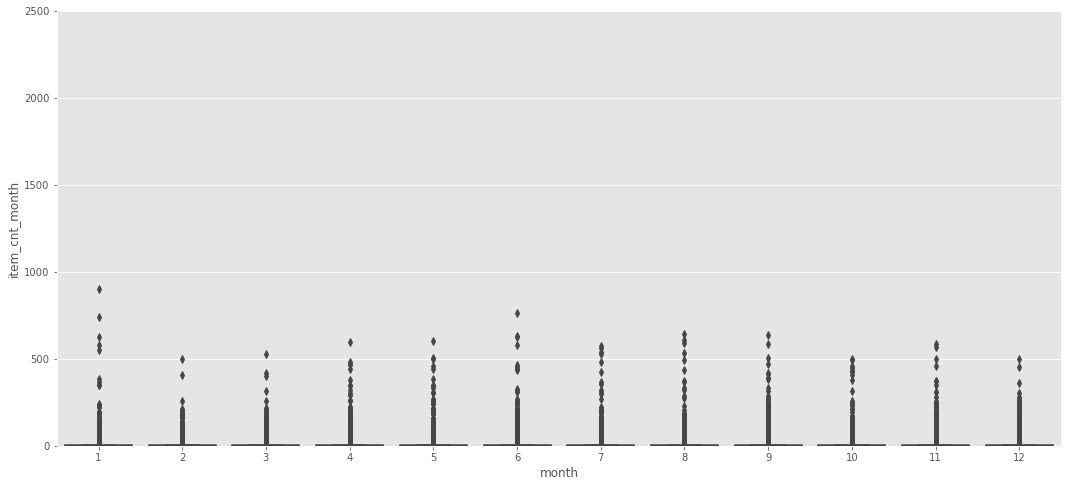

In [47]:
first = train["month"] == 2
second = train['item_cnt_month'] > 600
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 3
second = train['item_cnt_month'] > 600
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 7
second = train['item_cnt_month'] > 700
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 8
second = train['item_cnt_month'] > 750
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 9
second = train['item_cnt_month'] > 800
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 10
second = train['item_cnt_month'] > 550
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 11
second = train['item_cnt_month'] > 650
train = train.drop(train[first & second].index, axis=0)

first = train["month"] == 12
second = train['item_cnt_month'] > 600
train = train.drop(train[first & second].index, axis=0)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="month", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

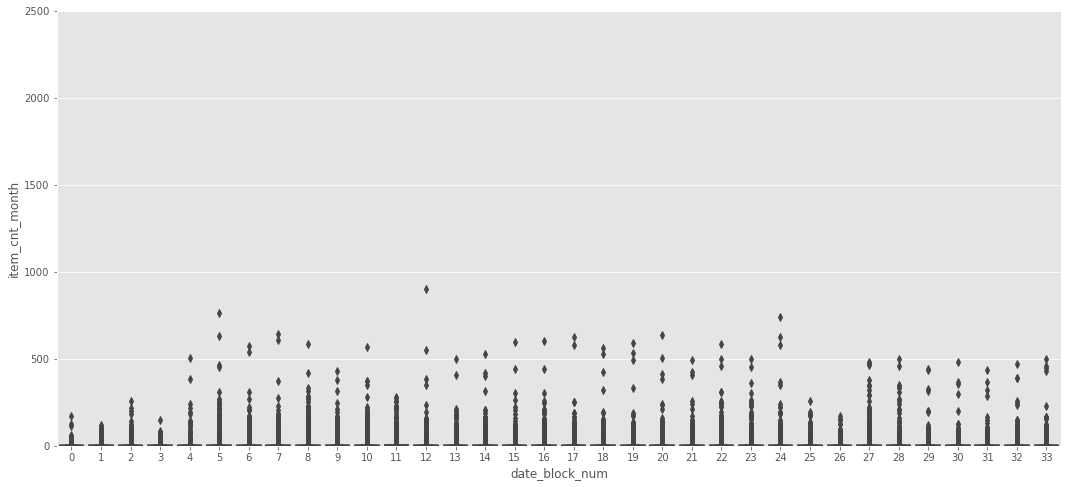

In [48]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="date_block_num", y="item_cnt_month")
plt.ylim(0, 2500)

(0.0, 2500.0)

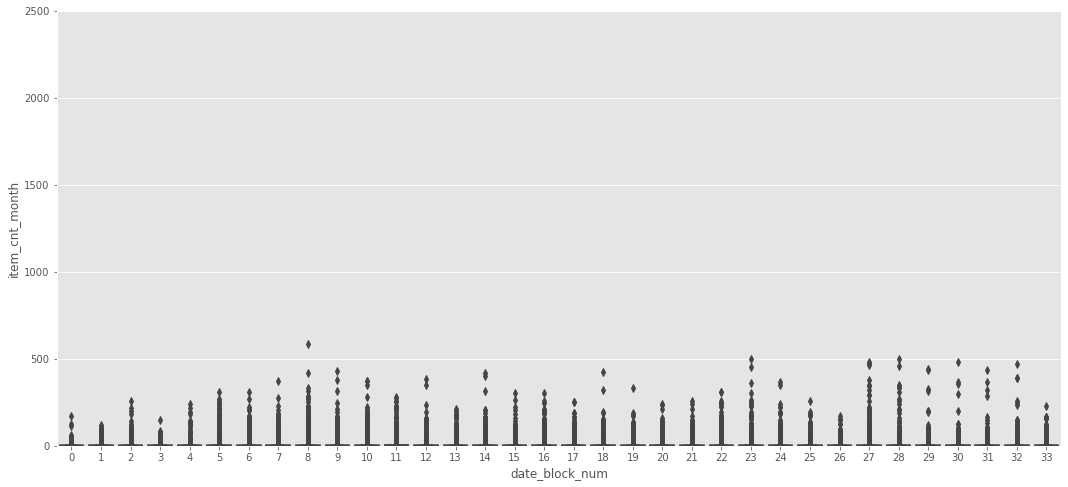

In [49]:
first = train["date_block_num"] == 4
second = train['item_cnt_month'] > 300
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 5
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 6
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 7
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 10
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 12
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 13
second = train['item_cnt_month'] > 300
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 14
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 15
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 16
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 17
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 18
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 19
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 20
second = train['item_cnt_month'] > 350
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 21
second = train['item_cnt_month'] > 350
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 22
second = train['item_cnt_month'] > 400
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 24
second = train['item_cnt_month'] > 500
train = train.drop(train[first & second].index, axis=0)

first = train["date_block_num"] == 33
second = train['item_cnt_month'] > 300
train = train.drop(train[first & second].index, axis=0)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.boxplot(data=train, x="date_block_num", y="item_cnt_month")
plt.ylim(0, 2500)

### 12) test 데이터와 test 데이터 합치기 + 정답데이터 분리하기

In [50]:
print('train data shape : {}'.format(train.shape))
print('test data shape : {}'.format(test.shape))

train data shape : (600067, 9)
test data shape : (214200, 8)


In [51]:
y = train["item_cnt_month"]
train.drop('item_cnt_month', axis=1, inplace=True)

train_len = len(train)
data = pd.concat((train, test), axis=0)

print('data shape : {}'.format(data.shape))
data

data shape : (814267, 8)


,date_block_num,shop_id,item_id,year,month,city_id,item_category_id,item_category_id2
0,0,59,22154,2013,1,30,37,7
1,0,25,2574,2013,1,13,55,9
2,0,25,2607,2013,1,13,55,9
3,0,25,2614,2013,1,13,55,9
4,0,25,2808,2013,1,13,30,5
...,...,...,...,...,...,...,...,...
214195,34,45,18454,2015,11,20,55,9
214196,34,45,16188,2015,11,20,64,10
214197,34,45,15757,2015,11,20,55,9
214198,34,45,19648,2015,11,20,40,7


/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_cnt_month', ylabel='Density'>

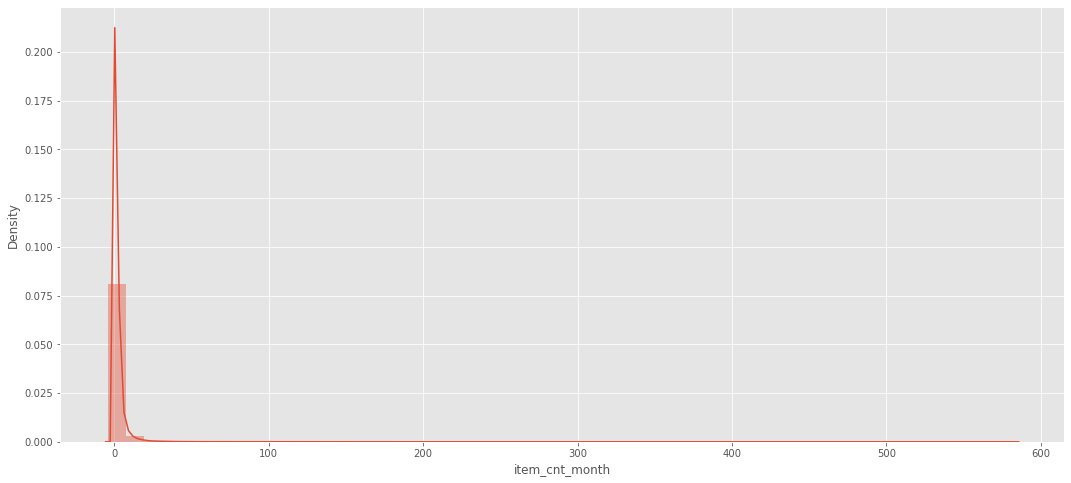

In [52]:
fig = plt.figure()

fig.set_size_inches(18, 8)

sns.distplot(y)

/home/aiffel-dj41/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='item_cnt_month', ylabel='Density'>

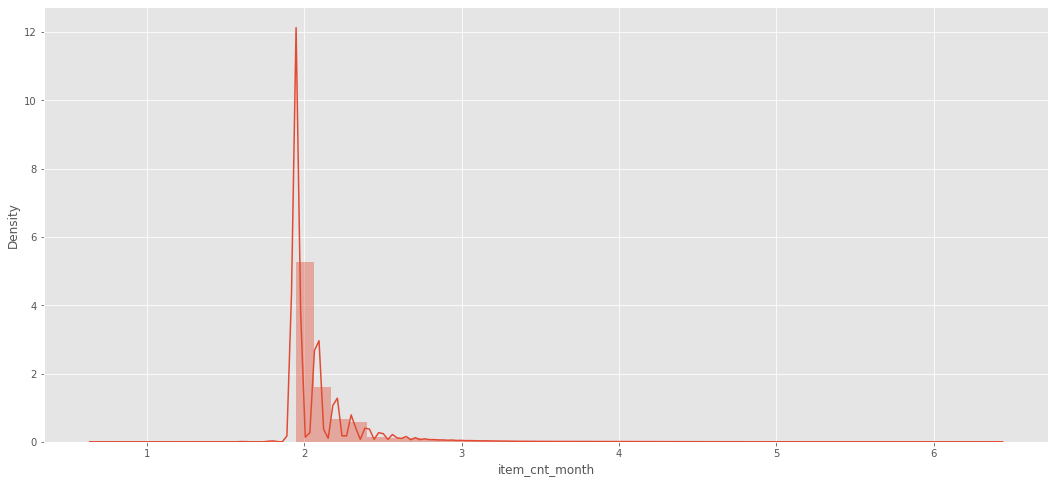

In [53]:
op = np.min(y.values)
y = y - op + 1
y = np.log1p(y)

fig = plt.figure()

fig.set_size_inches(18, 8)

sns.distplot(y)

In [54]:
print('전처리 전의 train data shape : {}'.format(train_data.shape))

print('전처리 후의 train data shape : {}'.format(train.shape))

전처리 전의 train data shape : (2935849, 6)
전처리 후의 train data shape : (600067, 8)


## 3. 하이퍼파라미터 튜닝

### 1) 모델 결정 - LGB Model

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

random_state=2021 

lightgbm = LGBMRegressor(random_state=random_state)

models = [lightgbm]

In [56]:
def get_scores(models, train, y):
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train, y)

,RMSE
LGBMRegressor,5.757471


### 2) 하이퍼 파라미터 튜닝

In [69]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)

    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']

    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score

    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

'''
param_grid = {
    'learning_rate' : [0.05, 0.1],
    'n_estimators': [100, 1000],
    'max_depth': [1, 10],
}
'''

param_grid = {
    'learning_rate' : [0.1],
    'n_estimators': [3000],
    'max_depth': [10],
    'feature_fraction': [0.7, 0.8, 0.9]
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:  4.6min finished


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,feature_fraction,learning_rate,max_depth,n_estimators,score,RMSLE
2,0.9,0.1,10,3000,-0.046685,0.216067
0,0.7,0.1,10,3000,-0.046721,0.216150
1,0.8,0.1,10,3000,-0.046721,0.216150


In [70]:
model = LGBMRegressor(max_depth=10, n_estimators=3000, learning_rate=0.1,
                      feature_fraction=0.9, random_state=random_state)
model.fit(train, y)
prediction = model.predict(test)

prediction = np.expm1(prediction)
prediction = prediction + op - 1

prediction

array([0.00818008, 1.0119314 , 0.00818008, ..., 0.92288829, 1.01951792,
       1.07486525])

In [71]:
test_data["item_cnt_month"] = prediction

sub = test_data.loc[:, ["ID", "item_cnt_month"]]

sub

,ID,item_cnt_month
0,0,0.008180
1,1,1.011931
2,2,0.008180
3,3,-0.387830
4,4,3.105639
...,...,...
214195,214195,0.922888
214196,214196,1.025495
214197,214197,0.922888
214198,214198,1.019518


In [72]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.216067')
sub.to_csv(submission_csv_path, index=False)

<img src="./image/lgbm_1000.png" alt="lgbm_1000"/>

<img src="./image/lgbm_3000.png" alt="lgbm_3000"/>

<img src="./image/lgbm_1000_9.png" alt="lgbm_1000_9"/>

<img src="./image/lgbm_3000_9.png" alt="lgbm_3000_9"/>

### 3) LGB Model의 업그레이드 버전, CatBoost Model

<img src="./image/catboost.png" alt="CatBoost"/>

- Catboost 는 기본 파라미터가 기본적으로 최적화가 잘 되어있어서, 파라미터 튜닝에 크게 신경쓰지 않아도 됩니다.

In [79]:
from catboost import CatBoostRegressor

param_grid = {
    'learning_rate' : [0.1],
    'n_estimators': [1000],
    'depth': [10],
    'rsm' : [0.7, 0.8, 0.9]
}

cboost = CatBoostRegressor(random_state=2021)
my_GridSearch(cboost, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  15 out of  15 | elapsed:  8.2min finished


0:	learn: 0.2757873	total: 52.6ms	remaining: 52.5s
1:	learn: 0.2710031	total: 97.6ms	remaining: 48.7s
2:	learn: 0.2669729	total: 146ms	remaining: 48.6s
3:	learn: 0.2633133	total: 186ms	remaining: 46.4s
4:	learn: 0.2606034	total: 227ms	remaining: 45.2s
5:	learn: 0.2580405	total: 268ms	remaining: 44.3s
6:	learn: 0.2559072	total: 307ms	remaining: 43.5s
7:	learn: 0.2541926	total: 352ms	remaining: 43.6s
8:	learn: 0.2527514	total: 388ms	remaining: 42.7s
9:	learn: 0.2512584	total: 424ms	remaining: 42s
10:	learn: 0.2502749	total: 462ms	remaining: 41.5s
11:	learn: 0.2493080	total: 509ms	remaining: 41.9s
12:	learn: 0.2484214	total: 575ms	remaining: 43.7s
13:	learn: 0.2475357	total: 615ms	remaining: 43.3s
14:	learn: 0.2465628	total: 652ms	remaining: 42.8s
15:	learn: 0.2454236	total: 688ms	remaining: 42.3s
16:	learn: 0.2445945	total: 726ms	remaining: 42s
17:	learn: 0.2435179	total: 772ms	remaining: 42.1s
18:	learn: 0.2427050	total: 808ms	remaining: 41.7s
19:	learn: 0.2420791	total: 848ms	remaining

161:	learn: 0.2115549	total: 7.04s	remaining: 36.4s
162:	learn: 0.2114054	total: 7.08s	remaining: 36.3s
163:	learn: 0.2113514	total: 7.13s	remaining: 36.3s
164:	learn: 0.2112597	total: 7.17s	remaining: 36.3s
165:	learn: 0.2111459	total: 7.2s	remaining: 36.2s
166:	learn: 0.2110818	total: 7.24s	remaining: 36.1s
167:	learn: 0.2109347	total: 7.28s	remaining: 36s
168:	learn: 0.2108324	total: 7.33s	remaining: 36s
169:	learn: 0.2105612	total: 7.37s	remaining: 36s
170:	learn: 0.2104406	total: 7.4s	remaining: 35.9s
171:	learn: 0.2102794	total: 7.45s	remaining: 35.8s
172:	learn: 0.2102228	total: 7.48s	remaining: 35.8s
173:	learn: 0.2101803	total: 7.53s	remaining: 35.8s
174:	learn: 0.2100876	total: 7.57s	remaining: 35.7s
175:	learn: 0.2100190	total: 7.61s	remaining: 35.6s
176:	learn: 0.2098764	total: 7.65s	remaining: 35.6s
177:	learn: 0.2097346	total: 7.68s	remaining: 35.5s
178:	learn: 0.2096731	total: 7.73s	remaining: 35.5s
179:	learn: 0.2096056	total: 7.77s	remaining: 35.4s
180:	learn: 0.209467

322:	learn: 0.1992502	total: 13.3s	remaining: 27.8s
323:	learn: 0.1992117	total: 13.3s	remaining: 27.8s
324:	learn: 0.1991789	total: 13.4s	remaining: 27.7s
325:	learn: 0.1991236	total: 13.4s	remaining: 27.7s
326:	learn: 0.1990963	total: 13.4s	remaining: 27.6s
327:	learn: 0.1990605	total: 13.5s	remaining: 27.6s
328:	learn: 0.1989643	total: 13.5s	remaining: 27.6s
329:	learn: 0.1989265	total: 13.6s	remaining: 27.5s
330:	learn: 0.1988962	total: 13.6s	remaining: 27.5s
331:	learn: 0.1988602	total: 13.6s	remaining: 27.4s
332:	learn: 0.1987663	total: 13.7s	remaining: 27.4s
333:	learn: 0.1987057	total: 13.7s	remaining: 27.3s
334:	learn: 0.1986783	total: 13.7s	remaining: 27.3s
335:	learn: 0.1986371	total: 13.8s	remaining: 27.2s
336:	learn: 0.1985993	total: 13.8s	remaining: 27.2s
337:	learn: 0.1985249	total: 13.9s	remaining: 27.1s
338:	learn: 0.1984967	total: 13.9s	remaining: 27.1s
339:	learn: 0.1984603	total: 13.9s	remaining: 27s
340:	learn: 0.1983756	total: 14s	remaining: 27s
341:	learn: 0.1983

481:	learn: 0.1927528	total: 19.5s	remaining: 21s
482:	learn: 0.1927218	total: 19.5s	remaining: 20.9s
483:	learn: 0.1927046	total: 19.6s	remaining: 20.9s
484:	learn: 0.1926794	total: 19.6s	remaining: 20.8s
485:	learn: 0.1926550	total: 19.6s	remaining: 20.8s
486:	learn: 0.1926114	total: 19.7s	remaining: 20.7s
487:	learn: 0.1925967	total: 19.7s	remaining: 20.7s
488:	learn: 0.1925757	total: 19.8s	remaining: 20.7s
489:	learn: 0.1925237	total: 19.8s	remaining: 20.6s
490:	learn: 0.1924958	total: 19.8s	remaining: 20.6s
491:	learn: 0.1924421	total: 19.9s	remaining: 20.5s
492:	learn: 0.1923909	total: 19.9s	remaining: 20.5s
493:	learn: 0.1923278	total: 20s	remaining: 20.4s
494:	learn: 0.1922749	total: 20s	remaining: 20.4s
495:	learn: 0.1922008	total: 20s	remaining: 20.4s
496:	learn: 0.1921666	total: 20.1s	remaining: 20.3s
497:	learn: 0.1921505	total: 20.1s	remaining: 20.3s
498:	learn: 0.1921233	total: 20.2s	remaining: 20.2s
499:	learn: 0.1920903	total: 20.2s	remaining: 20.2s
500:	learn: 0.192075

642:	learn: 0.1878414	total: 25.8s	remaining: 14.3s
643:	learn: 0.1878151	total: 25.9s	remaining: 14.3s
644:	learn: 0.1877921	total: 25.9s	remaining: 14.3s
645:	learn: 0.1877764	total: 25.9s	remaining: 14.2s
646:	learn: 0.1877639	total: 26s	remaining: 14.2s
647:	learn: 0.1877374	total: 26s	remaining: 14.1s
648:	learn: 0.1877156	total: 26.1s	remaining: 14.1s
649:	learn: 0.1876921	total: 26.1s	remaining: 14.1s
650:	learn: 0.1876745	total: 26.2s	remaining: 14s
651:	learn: 0.1876523	total: 26.2s	remaining: 14s
652:	learn: 0.1876268	total: 26.3s	remaining: 14s
653:	learn: 0.1875976	total: 26.3s	remaining: 13.9s
654:	learn: 0.1875839	total: 26.4s	remaining: 13.9s
655:	learn: 0.1875692	total: 26.4s	remaining: 13.8s
656:	learn: 0.1875183	total: 26.5s	remaining: 13.8s
657:	learn: 0.1874833	total: 26.5s	remaining: 13.8s
658:	learn: 0.1874652	total: 26.6s	remaining: 13.7s
659:	learn: 0.1874454	total: 26.6s	remaining: 13.7s
660:	learn: 0.1874137	total: 26.7s	remaining: 13.7s
661:	learn: 0.1873863	

805:	learn: 0.1843995	total: 33.3s	remaining: 8.02s
806:	learn: 0.1843867	total: 33.4s	remaining: 7.98s
807:	learn: 0.1843678	total: 33.4s	remaining: 7.95s
808:	learn: 0.1843486	total: 33.5s	remaining: 7.9s
809:	learn: 0.1843191	total: 33.5s	remaining: 7.86s
810:	learn: 0.1843020	total: 33.6s	remaining: 7.82s
811:	learn: 0.1842819	total: 33.6s	remaining: 7.78s
812:	learn: 0.1842584	total: 33.7s	remaining: 7.74s
813:	learn: 0.1842388	total: 33.7s	remaining: 7.7s
814:	learn: 0.1842231	total: 33.7s	remaining: 7.66s
815:	learn: 0.1842043	total: 33.8s	remaining: 7.62s
816:	learn: 0.1841614	total: 33.8s	remaining: 7.58s
817:	learn: 0.1841416	total: 33.9s	remaining: 7.54s
818:	learn: 0.1841180	total: 33.9s	remaining: 7.5s
819:	learn: 0.1841073	total: 34s	remaining: 7.45s
820:	learn: 0.1840823	total: 34s	remaining: 7.41s
821:	learn: 0.1840702	total: 34s	remaining: 7.37s
822:	learn: 0.1840600	total: 34.1s	remaining: 7.33s
823:	learn: 0.1840454	total: 34.1s	remaining: 7.29s
824:	learn: 0.1840203

964:	learn: 0.1816147	total: 40.3s	remaining: 1.46s
965:	learn: 0.1815843	total: 40.3s	remaining: 1.42s
966:	learn: 0.1815614	total: 40.4s	remaining: 1.38s
967:	learn: 0.1815526	total: 40.4s	remaining: 1.34s
968:	learn: 0.1815349	total: 40.5s	remaining: 1.29s
969:	learn: 0.1815135	total: 40.5s	remaining: 1.25s
970:	learn: 0.1815021	total: 40.5s	remaining: 1.21s
971:	learn: 0.1814908	total: 40.6s	remaining: 1.17s
972:	learn: 0.1814761	total: 40.6s	remaining: 1.13s
973:	learn: 0.1814608	total: 40.7s	remaining: 1.08s
974:	learn: 0.1814494	total: 40.7s	remaining: 1.04s
975:	learn: 0.1814364	total: 40.8s	remaining: 1s
976:	learn: 0.1814286	total: 40.8s	remaining: 960ms
977:	learn: 0.1814183	total: 40.8s	remaining: 919ms
978:	learn: 0.1814008	total: 40.9s	remaining: 877ms
979:	learn: 0.1813775	total: 40.9s	remaining: 835ms
980:	learn: 0.1813572	total: 41s	remaining: 793ms
981:	learn: 0.1813414	total: 41s	remaining: 752ms
982:	learn: 0.1813213	total: 41s	remaining: 710ms
983:	learn: 0.1812749

,depth,learning_rate,n_estimators,rsm,score,RMSLE
2,10,0.1,1000,0.9,-0.047775,0.218575
1,10,0.1,1000,0.8,-0.047833,0.218708
0,10,0.1,1000,0.7,-0.047903,0.218869


In [80]:
from catboost import CatBoostRegressor

cboost = CatBoostRegressor(learning_rate=0.1, n_estimators=1000,
                           depth=10, rsm=0.9 ,random_state=random_state)

cboost.fit(train, y)

prediction = cboost.predict(test)

0:	learn: 0.2757873	total: 39ms	remaining: 38.9s
1:	learn: 0.2710031	total: 82.3ms	remaining: 41.1s
2:	learn: 0.2669729	total: 120ms	remaining: 39.9s
3:	learn: 0.2633133	total: 180ms	remaining: 44.9s
4:	learn: 0.2606034	total: 224ms	remaining: 44.6s
5:	learn: 0.2580405	total: 276ms	remaining: 45.7s
6:	learn: 0.2559072	total: 324ms	remaining: 45.9s
7:	learn: 0.2541926	total: 373ms	remaining: 46.2s
8:	learn: 0.2527514	total: 417ms	remaining: 45.9s
9:	learn: 0.2512584	total: 458ms	remaining: 45.4s
10:	learn: 0.2502749	total: 507ms	remaining: 45.6s
11:	learn: 0.2493080	total: 553ms	remaining: 45.5s
12:	learn: 0.2484214	total: 609ms	remaining: 46.3s
13:	learn: 0.2475357	total: 678ms	remaining: 47.8s
14:	learn: 0.2465628	total: 742ms	remaining: 48.7s
15:	learn: 0.2454236	total: 888ms	remaining: 54.6s
16:	learn: 0.2445945	total: 982ms	remaining: 56.8s
17:	learn: 0.2435179	total: 1.08s	remaining: 59s
18:	learn: 0.2427050	total: 1.14s	remaining: 59s
19:	learn: 0.2420791	total: 1.21s	remaining: 

162:	learn: 0.2114054	total: 8.77s	remaining: 45s
163:	learn: 0.2113514	total: 8.82s	remaining: 45s
164:	learn: 0.2112597	total: 8.88s	remaining: 44.9s
165:	learn: 0.2111459	total: 8.93s	remaining: 44.9s
166:	learn: 0.2110818	total: 9.04s	remaining: 45.1s
167:	learn: 0.2109347	total: 9.08s	remaining: 45s
168:	learn: 0.2108324	total: 9.13s	remaining: 44.9s
169:	learn: 0.2105612	total: 9.17s	remaining: 44.8s
170:	learn: 0.2104406	total: 9.21s	remaining: 44.7s
171:	learn: 0.2102794	total: 9.26s	remaining: 44.6s
172:	learn: 0.2102228	total: 9.3s	remaining: 44.5s
173:	learn: 0.2101803	total: 9.37s	remaining: 44.5s
174:	learn: 0.2100876	total: 9.43s	remaining: 44.5s
175:	learn: 0.2100190	total: 9.49s	remaining: 44.4s
176:	learn: 0.2098764	total: 9.55s	remaining: 44.4s
177:	learn: 0.2097346	total: 9.61s	remaining: 44.4s
178:	learn: 0.2096731	total: 9.65s	remaining: 44.3s
179:	learn: 0.2096056	total: 9.69s	remaining: 44.2s
180:	learn: 0.2094671	total: 9.74s	remaining: 44.1s
181:	learn: 0.20929

325:	learn: 0.1991236	total: 16.8s	remaining: 34.7s
326:	learn: 0.1990963	total: 16.8s	remaining: 34.6s
327:	learn: 0.1990605	total: 16.9s	remaining: 34.5s
328:	learn: 0.1989643	total: 16.9s	remaining: 34.5s
329:	learn: 0.1989265	total: 17s	remaining: 34.4s
330:	learn: 0.1988962	total: 17s	remaining: 34.4s
331:	learn: 0.1988602	total: 17s	remaining: 34.3s
332:	learn: 0.1987663	total: 17.1s	remaining: 34.2s
333:	learn: 0.1987057	total: 17.1s	remaining: 34.2s
334:	learn: 0.1986783	total: 17.2s	remaining: 34.1s
335:	learn: 0.1986371	total: 17.2s	remaining: 34s
336:	learn: 0.1985993	total: 17.3s	remaining: 34s
337:	learn: 0.1985249	total: 17.3s	remaining: 33.9s
338:	learn: 0.1984967	total: 17.3s	remaining: 33.8s
339:	learn: 0.1984603	total: 17.4s	remaining: 33.8s
340:	learn: 0.1983756	total: 17.4s	remaining: 33.7s
341:	learn: 0.1983224	total: 17.5s	remaining: 33.6s
342:	learn: 0.1982307	total: 17.5s	remaining: 33.5s
343:	learn: 0.1982031	total: 17.6s	remaining: 33.5s
344:	learn: 0.1981623	

485:	learn: 0.1926550	total: 24.1s	remaining: 25.5s
486:	learn: 0.1926114	total: 24.1s	remaining: 25.4s
487:	learn: 0.1925967	total: 24.2s	remaining: 25.4s
488:	learn: 0.1925757	total: 24.2s	remaining: 25.3s
489:	learn: 0.1925237	total: 24.3s	remaining: 25.3s
490:	learn: 0.1924958	total: 24.3s	remaining: 25.2s
491:	learn: 0.1924421	total: 24.4s	remaining: 25.1s
492:	learn: 0.1923909	total: 24.4s	remaining: 25.1s
493:	learn: 0.1923278	total: 24.4s	remaining: 25s
494:	learn: 0.1922749	total: 24.5s	remaining: 25s
495:	learn: 0.1922008	total: 24.5s	remaining: 24.9s
496:	learn: 0.1921666	total: 24.6s	remaining: 24.9s
497:	learn: 0.1921505	total: 24.6s	remaining: 24.8s
498:	learn: 0.1921233	total: 24.6s	remaining: 24.7s
499:	learn: 0.1920903	total: 24.7s	remaining: 24.7s
500:	learn: 0.1920755	total: 24.7s	remaining: 24.6s
501:	learn: 0.1920390	total: 24.8s	remaining: 24.6s
502:	learn: 0.1919716	total: 24.8s	remaining: 24.5s
503:	learn: 0.1919527	total: 24.9s	remaining: 24.5s
504:	learn: 0.19

648:	learn: 0.1877156	total: 31.3s	remaining: 16.9s
649:	learn: 0.1876921	total: 31.3s	remaining: 16.9s
650:	learn: 0.1876745	total: 31.4s	remaining: 16.8s
651:	learn: 0.1876523	total: 31.4s	remaining: 16.8s
652:	learn: 0.1876268	total: 31.5s	remaining: 16.7s
653:	learn: 0.1875976	total: 31.5s	remaining: 16.7s
654:	learn: 0.1875839	total: 31.6s	remaining: 16.6s
655:	learn: 0.1875692	total: 31.6s	remaining: 16.6s
656:	learn: 0.1875183	total: 31.6s	remaining: 16.5s
657:	learn: 0.1874833	total: 31.7s	remaining: 16.5s
658:	learn: 0.1874652	total: 31.7s	remaining: 16.4s
659:	learn: 0.1874454	total: 31.8s	remaining: 16.4s
660:	learn: 0.1874137	total: 31.8s	remaining: 16.3s
661:	learn: 0.1873863	total: 31.9s	remaining: 16.3s
662:	learn: 0.1873714	total: 31.9s	remaining: 16.2s
663:	learn: 0.1873535	total: 32s	remaining: 16.2s
664:	learn: 0.1873303	total: 32s	remaining: 16.1s
665:	learn: 0.1873000	total: 32.1s	remaining: 16.1s
666:	learn: 0.1872801	total: 32.1s	remaining: 16s
667:	learn: 0.1872

808:	learn: 0.1843486	total: 38.2s	remaining: 9.02s
809:	learn: 0.1843191	total: 38.3s	remaining: 8.97s
810:	learn: 0.1843020	total: 38.3s	remaining: 8.93s
811:	learn: 0.1842819	total: 38.3s	remaining: 8.88s
812:	learn: 0.1842584	total: 38.4s	remaining: 8.83s
813:	learn: 0.1842388	total: 38.4s	remaining: 8.78s
814:	learn: 0.1842231	total: 38.5s	remaining: 8.73s
815:	learn: 0.1842043	total: 38.5s	remaining: 8.68s
816:	learn: 0.1841614	total: 38.5s	remaining: 8.63s
817:	learn: 0.1841416	total: 38.6s	remaining: 8.59s
818:	learn: 0.1841180	total: 38.6s	remaining: 8.54s
819:	learn: 0.1841073	total: 38.7s	remaining: 8.49s
820:	learn: 0.1840823	total: 38.7s	remaining: 8.45s
821:	learn: 0.1840702	total: 38.8s	remaining: 8.4s
822:	learn: 0.1840600	total: 38.8s	remaining: 8.35s
823:	learn: 0.1840454	total: 38.9s	remaining: 8.3s
824:	learn: 0.1840203	total: 38.9s	remaining: 8.25s
825:	learn: 0.1840081	total: 39s	remaining: 8.21s
826:	learn: 0.1839739	total: 39s	remaining: 8.16s
827:	learn: 0.1839

971:	learn: 0.1814908	total: 45.3s	remaining: 1.3s
972:	learn: 0.1814761	total: 45.3s	remaining: 1.26s
973:	learn: 0.1814608	total: 45.3s	remaining: 1.21s
974:	learn: 0.1814494	total: 45.4s	remaining: 1.16s
975:	learn: 0.1814364	total: 45.4s	remaining: 1.12s
976:	learn: 0.1814286	total: 45.5s	remaining: 1.07s
977:	learn: 0.1814183	total: 45.5s	remaining: 1.02s
978:	learn: 0.1814008	total: 45.5s	remaining: 977ms
979:	learn: 0.1813775	total: 45.6s	remaining: 930ms
980:	learn: 0.1813572	total: 45.6s	remaining: 883ms
981:	learn: 0.1813414	total: 45.7s	remaining: 837ms
982:	learn: 0.1813213	total: 45.7s	remaining: 790ms
983:	learn: 0.1812749	total: 45.8s	remaining: 744ms
984:	learn: 0.1812642	total: 45.8s	remaining: 697ms
985:	learn: 0.1812503	total: 45.9s	remaining: 651ms
986:	learn: 0.1812314	total: 45.9s	remaining: 604ms
987:	learn: 0.1811956	total: 45.9s	remaining: 558ms
988:	learn: 0.1811823	total: 46s	remaining: 511ms
989:	learn: 0.1811743	total: 46s	remaining: 465ms
990:	learn: 0.181

In [81]:
prediction = np.expm1(prediction)
prediction = prediction + op - 1

prediction

array([1.48393569, 1.71042877, 1.42098117, ..., 1.00591499, 1.13304897,
       0.65236432])

In [77]:
test_data["item_cnt_month"] = prediction

sub = test_data.loc[:, ["ID", "item_cnt_month"]]

sub

,ID,item_cnt_month
0,0,1.563172
1,1,1.626959
2,2,1.482739
3,3,1.448516
4,4,0.882808
...,...,...
214195,214195,1.217552
214196,214196,1.125311
214197,214197,1.024075
214198,214198,1.217156


In [82]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'cboost', '0.218575')
sub.to_csv(submission_csv_path, index=False)

<img src="./image/catboost_ver.png" alt="catboost" width="100%"/>

<img src="./image/catboost_1000-2.png" alt="catboost_1000-2"/>

<img src="./image/catboost_1000_9.png" alt="catboost_1000_9"/>

<img src="./image/perfect.png" alt="Final"/>